# Pyspark

In [ ]:
import pyspark

In [ ]:
pyspark.__version__

## Creating a cluster

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[1]').appName('testing_spark').getOrCreate()


In [ ]:
# Good practice is to stop the cluster 
# spark.stop()

# DataFrames

In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType

data = [
    (1, "John", 28, 175.5),
    (2, "Anna", 23, 160.2),
    (3, "Mike", 35, 180.3)
]

# Define the schema with specific data types
schema = StructType([
    StructField("ID", IntegerType(), True),
    StructField("Name", StringType(), True),
    StructField("Age", IntegerType(), True),
    StructField("Height", FloatType(), True)
])

# Create the DataFrame with the defined schema
df = spark.createDataFrame(data, schema=schema)

# Show the DataFrame
df.show()

# Print the schema to verify data types
df.printSchema()

## Loading Data 

In [ ]:
cars = spark.read.csv('data/cars.csv', header=True)
cars.limit(10).toPandas().head()

Loading data has the following arguments: 
- header: is the first ow a header?
- sep: field separator
- schema: explicit column data types
- inferSchema: deduca column data types from data
- nullValue: placeholder for missing data


In [ ]:
cars.printSchema()

At this point everything is a string in this dataframe!! 

We can let spark infer the data types of each column or explicitly define their types.



In [ ]:
cars = spark.read.csv('data/cars.csv', header=True, inferSchema=True)
cars.limit(10).toPandas().head()

In [ ]:
cars.printSchema()

Null values could mislead spark and assign string due to the presence of 'NA' or similar strings.

If automatic type inference is not applicable we can explicitly declare the data types like: 

In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType

data = [
    (1, "John", 28, 175.5),
    (2, "Anna", 23, 160.2),
    (3, "Mike", 35, 180.3)
]

# Define the schema with specific data types
schema = StructType([
    StructField("ID", IntegerType(), True),
    StructField("Name", StringType(), True),
    StructField("Age", IntegerType(), True),
    StructField("Height", FloatType(), True)
])

# Create the DataFrame with the defined schema
df = spark.createDataFrame(data, schema=schema)

# Show the DataFrame
df.show()

# Print the schema to verify data types
df.printSchema()

In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

# Specify column names and types
schema = StructType([
    StructField("id", IntegerType()),
    StructField("text", StringType()),
    StructField("label", IntegerType())
])

# Load data from a delimited file
sms = spark.read.csv('data/sms.csv', sep=';', header=False, schema=schema)

# Print schema of DataFrame
sms.printSchema()

In [ ]:
# Read data from CSV file
flights = spark.read.csv('data/flights.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')

# Get number of records
print("The data contain %d records." % flights.count())

# View the first five records
flights.show(5)

# Check column data types
print(flights.dtypes)

# Data Preparation

In [ ]:
cars = spark.read.csv('data/auto.csv', header=True, inferSchema=True)
cars.limit(10).toPandas().head()

In [ ]:
cars.limit(10).toPandas().columns

In [ ]:
cars = cars.drop('name')

In [ ]:
cars = cars.select('origin', 'cylinders', 'weight', 'horsepower', 'mpg')

In [ ]:
cars.filter('cylinders IS NULL').count()

In [ ]:
cars.filter('weight IS NULL').count()

In [ ]:
cars.filter('mpg IS NULL').count()

In [ ]:
from pyspark.sql.functions import round

cars = cars.withColumn('mass', round(cars.weight/2.205, 0))

In [ ]:
cars.limit(10).toPandas().head()

In [ ]:
from pyspark.ml.feature import StringIndexer 

indexer = StringIndexer(inputCol='origin', outputCol='origin_idx')

indexer = indexer.fit(cars)

cars = indexer.transform(cars)

In [ ]:
cars.limit(100).toPandas().head(20)

The final step in preparing the cars data is to consolidate the various input columns into a single column. This is necessary because the Machine Learning algorithms in Spark operate on a single vector of predictors, although each element in that vector may consist of multiple values.

In [ ]:
cars.limit(100).toPandas().head(20)

In [ ]:
# Remove the 'flight' column
flights_drop_column = flights.drop('flight')

# Number of records with missing 'delay' values
flights_drop_column.filter('delay IS NULL').count()

# Remove records with missing 'delay' values
flights_valid_delay = flights_drop_column.filter('delay IS NOT NULL')

# Remove records with missing values in any column and get the number of remaining rows
flights_none_missing = flights_valid_delay.dropna()
print(flights_none_missing.count())

In [ ]:
# Import the required function
from pyspark.sql.functions import round

# Convert 'mile' to 'km' and drop 'mile' column (1 mile is equivalent to 1.60934 km)
flights_km = flights.withColumn('km', round(flights.mile * 1.60934, 0)) \
                    .drop('mile')

# Create 'label' column indicating whether flight delayed (1) or not (0)
flights_km = flights_km.withColumn('label', (flights_km.delay >= 15).cast('integer'))

# Check first five records
flights_km.show(5)

In [ ]:
from pyspark.ml.feature import StringIndexer

# Create an indexer
indexer = StringIndexer(inputCol='carrier', outputCol='carrier_idx')

# Indexer identifies categories in the data
indexer_model = indexer.fit(flights_km)

# Indexer creates a new column with numeric index values
flights_indexed = indexer_model.transform(flights_km)

# Repeat the process for the other categorical feature
flights_indexed = StringIndexer(inputCol='org', outputCol='org_idx').fit(flights_indexed).transform(flights_indexed)
flights_indexed.show(5)

In [ ]:
# Import the necessary class
from pyspark.ml.feature import VectorAssembler

# Create an assembler object
assembler = VectorAssembler(inputCols=[
    'mon', 'dom', 'dow','carrier_idx','org_idx','km','depart','duration'
], outputCol='features')

# Consolidate predictor columns
flights_assembled = assembler.transform(flights_indexed)

# Check the resulting column
flights_assembled.select('features', 'delay').show(5, truncate=False)

# Decision Tree

In [ ]:
cars.toPandas().head()

In [ ]:
assembler = VectorAssembler(inputCols=['cylinders', 'mpg', 'horsepower'], outputCol = 'features')
cars = assembler.transform(cars)


In [ ]:
cars = cars.withColumn('label', cars.origin_idx)

In [ ]:
cars_train, cars_test = cars.randomSplit([0.8, 0.2], seed=23)

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier 

tree = DecisionTreeClassifier() 

tree_model = tree.fit(cars_train)
                      

In [ ]:
prediction = tree_model.transform(cars_test)

In [ ]:
prediction.show()

In [ ]:
prediction.groupBy('label', 'prediction').count().show()

In [ ]:
flights_assembled = flights_assembled.filter('label IS NOT NULL')

# Split into training and testing sets in a 80:20 ratio
flights_train, flights_test = flights_assembled.randomSplit([0.8, 0.2], seed=43)

# Check that training set has around 80% of records
training_ratio = flights_train.count() / flights.count()
print(training_ratio)

In [ ]:
flights.show()

In [ ]:
# Import the Decision Tree Classifier class
from pyspark.ml.classification import DecisionTreeClassifier

# Create a classifier object and fit to the training data
tree = DecisionTreeClassifier()
tree_model = tree.fit(flights_train)

# Create predictions for the testing data and take a look at the predictions
prediction = tree_model.transform(flights_test)
prediction.select('label', 'prediction', 'probability').show(5, False)

In [ ]:
# Create a confusion matrix
prediction.groupBy('label', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND label = prediction').count()
TP = prediction.filter('prediction = 1 AND label = prediction').count()
FN = prediction.filter('prediction = 0 AND label != prediction').count()
FP = prediction.filter('prediction = 1 AND label != prediction').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TP + TN)/prediction.count()
print(accuracy)

# Logistic Regression 


In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression() 

lr = lr.fit(cars_train)

In [ ]:
prediction = lr.transform(cars_test)
prediction.toPandas().head(20)

In [ ]:
# Create a confusion matrix
prediction.groupBy('label', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND label = prediction').count()
TP = prediction.filter('prediction = 1 AND label = prediction').count()
FN = prediction.filter('prediction = 0 AND label != prediction').count()
FP = prediction.filter('prediction = 1 AND label != prediction').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TP + TN)/prediction.count()
print(accuracy)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator()
evaluator.evaluate(prediction,{evaluator.metricName : 'weightedPrecision'})

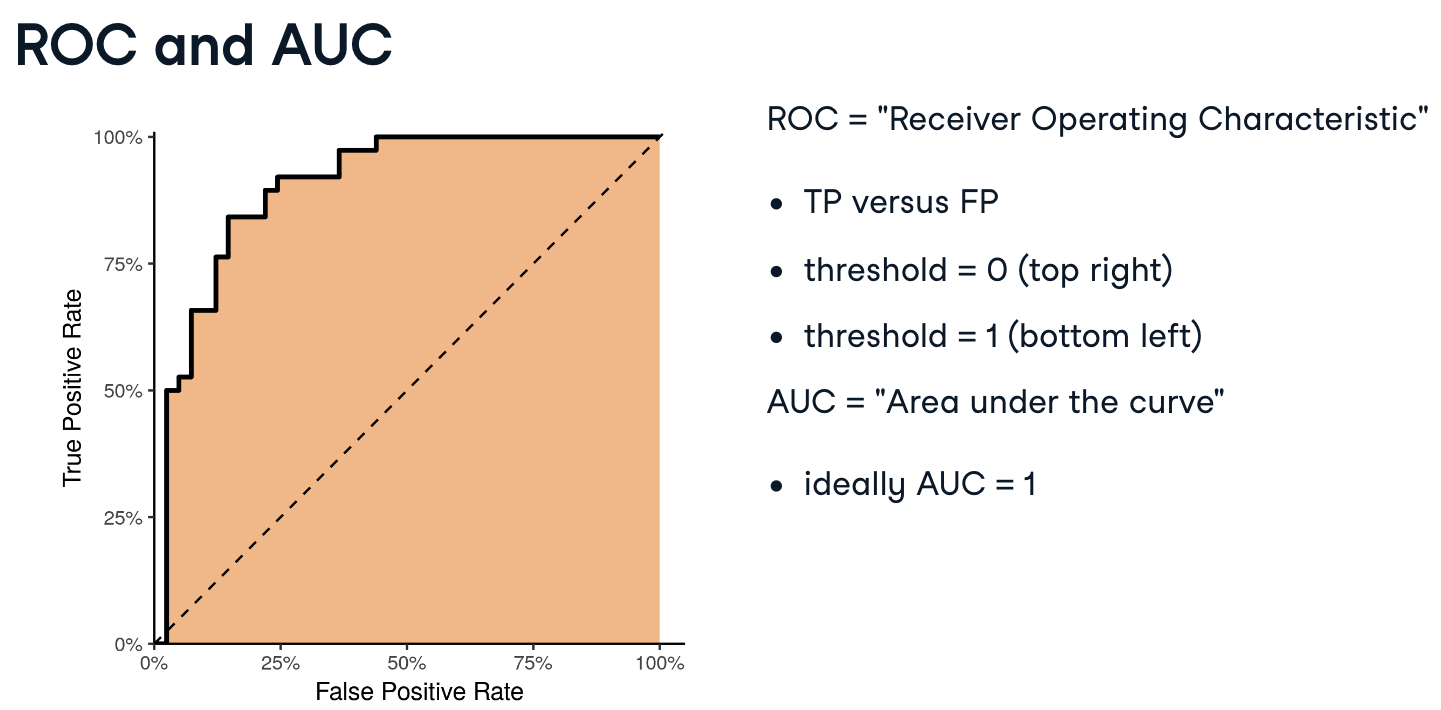


In [ ]:
# Import the logistic regression class
from pyspark.ml.classification import LogisticRegression

# Create a classifier object and train on training data
logistic = LogisticRegression().fit(flights_train)

# Create predictions for the testing data and show confusion matrix
prediction = logistic.transform(flights_test)
prediction.groupBy('label', 'prediction').count().show()

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Calculate precision and recall
precision = TP/(TP+FP)
recall = TP/(TP+FN)
print('precision = {:.2f}\nrecall    = {:.2f}'.format(precision, recall))

# Find weighted precision
multi_evaluator = MulticlassClassificationEvaluator()
weighted_precision = multi_evaluator.evaluate(prediction, {multi_evaluator.metricName: "weightedPrecision"})

# Find AUC
binary_evaluator = BinaryClassificationEvaluator()
auc = binary_evaluator.evaluate(prediction, {binary_evaluator.metricName: 'areaUnderROC'})

# Turning Text into Tables 

In [ ]:
sms = spark.read.csv('data/sms.csv', sep=';', header=False, schema=schema)

sms.toPandas().head()

In [ ]:
# Import the necessary functions
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import Tokenizer

# Remove punctuation (REGEX provided) and numbers
wrangled = sms.withColumn('text', regexp_replace(sms.text, '[_():;,.!?\\-]', ' '))
wrangled = wrangled.withColumn('text', regexp_replace(wrangled.text, '[0-9]', ' '))

# Merge multiple spaces
wrangled = wrangled.withColumn('text', regexp_replace(wrangled.text, ' +', ' '))

# Split the text into words
wrangled = Tokenizer(inputCol='text', outputCol='words').transform(wrangled)

wrangled.show(4, truncate=False)

In [ ]:
from pyspark.ml.feature import StopWordsRemover, HashingTF, IDF

# Remove stop words.
wrangled = StopWordsRemover(inputCol='words', outputCol='terms')\
      .transform(wrangled)

# Apply the hashing trick
wrangled = HashingTF(inputCol='terms', outputCol='hash', numFeatures=1024)\
      .transform(wrangled)

# Convert hashed symbols to TF-IDF
tf_idf = IDF(inputCol='hash', outputCol='features')\
      .fit(wrangled).transform(wrangled)
      
tf_idf.select('terms', 'features').show(4, truncate=False)

In [ ]:
# Split the data into training and testing sets
sms_train, sms_test = tf_idf.randomSplit([0.8, 0.2], seed=13)

# Fit a Logistic Regression model to the training data
logistic = LogisticRegression(regParam=0.2).fit(sms_train)

# Make predictions on the testing data
prediction = logistic.transform(sms_test)

# Create a confusion matrix, comparing predictions to known labels
prediction.groupBy('label', 'prediction').count().show()